# GeoBench BigEarthNetV2

In [ ]:
import os
from pathlib import Path

import torch

from geobench_v2.datamodules import GeoBenchBENV2DataModule
from geobench_v2.datasets import GeoBenchBENV2
from geobench_v2.datasets.normalization import SatMAENormalizer, ZScoreNormalizer
from geobench_v2.datasets.visualization_util import (
    compare_normalization_methods,
    compute_batch_histograms,
    plot_batch_histograms,
    plot_channel_histograms,
)

%load_ext autoreload
%autoreload 2

In [ ]:
PROJECT_ROOT = Path("../../")

STATS_SATMAE_PATH = os.path.join(
    PROJECT_ROOT, "geobench_v2", "datamodules", "dataset_stats_satmae", "benv2", "benv2_stats.json"
)
STATS_CLIP_RESCALE_PATH = os.path.join(
    PROJECT_ROOT, "geobench_v2", "datamodules", "dataset_stats_clip_rescale", "benv2", "benv2_stats.json"
)


In [3]:
band_order = GeoBenchBENV2.band_default_order

datamodule = GeoBenchBENV2DataModule(
    img_size=120,
    batch_size=16,
    num_workers=4,
    root=PROJECT_ROOT / "data" / "benv2",
    band_order=band_order,
    data_normalizer=torch.nn.Identity(),  # we do custom normalization in the tutorial
)
datamodule.setup("fit")

Using provided pre-initialized normalizer instance: Identity
Using provided pre-initialized normalizer instance: Identity


Map extent: Longitude [-13.99° to 36.54°], Latitude [31.96° to 72.97°]
Found 3 dataset splits: train, test, validation


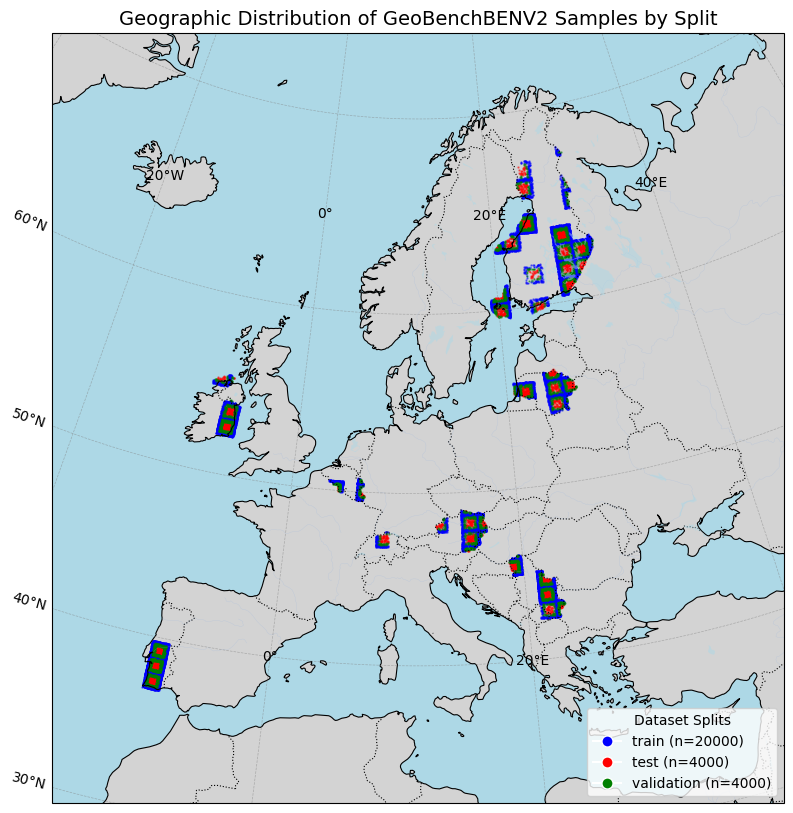

In [4]:
sample_dist_fig = datamodule.visualize_geospatial_distribution()

## Dataset Statistics

### Image Dataset Statistics

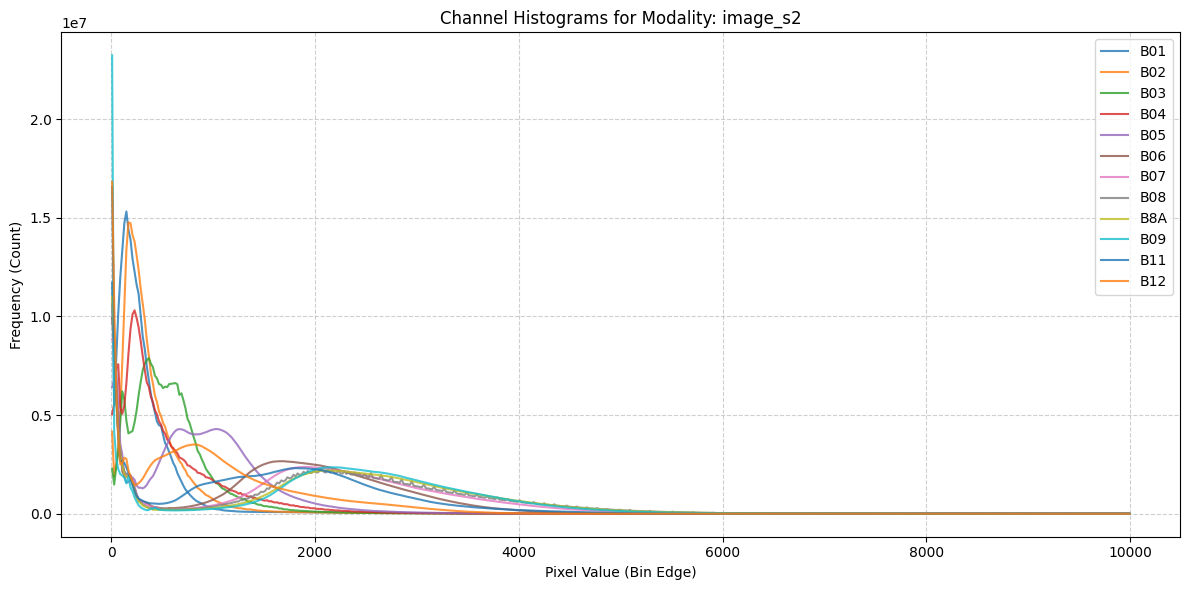

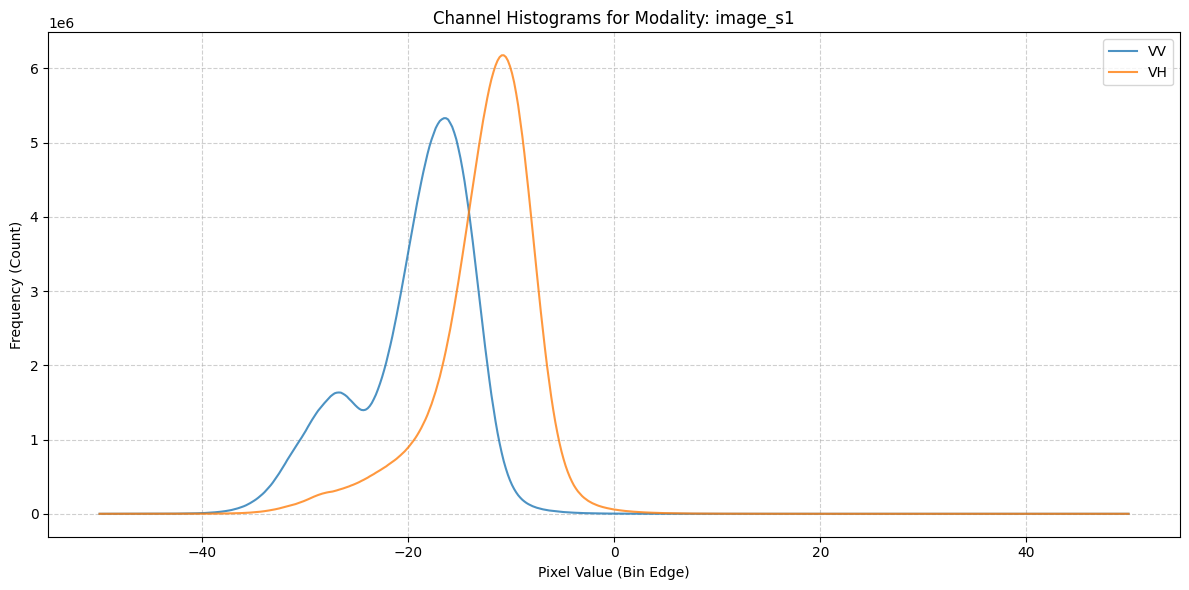

In [6]:
fig = plot_channel_histograms(STATS_SATMAE_PATH)

### Target Statistics

### Raw Batch Image Statistics

Statistics of a single batch before any normalization

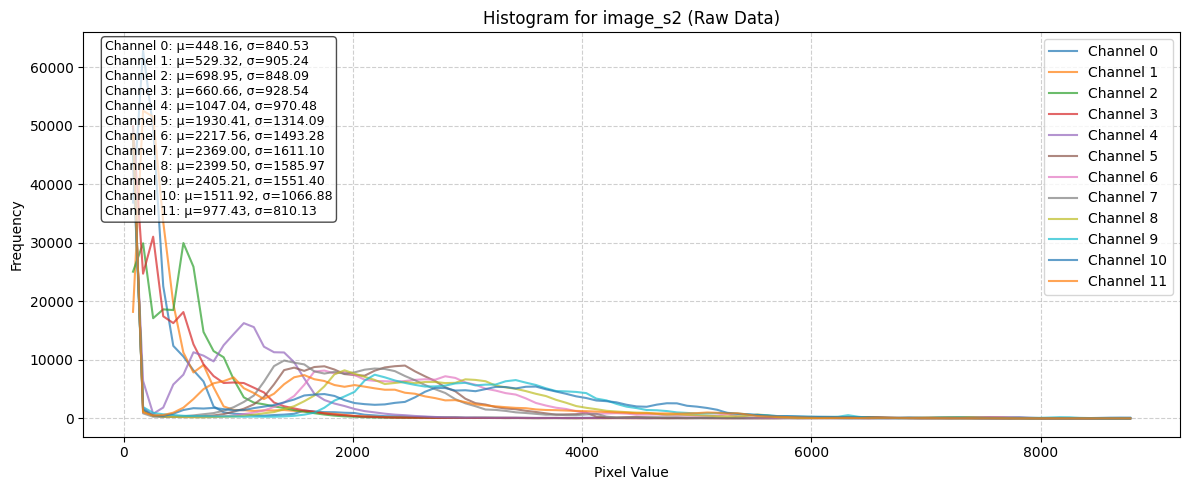

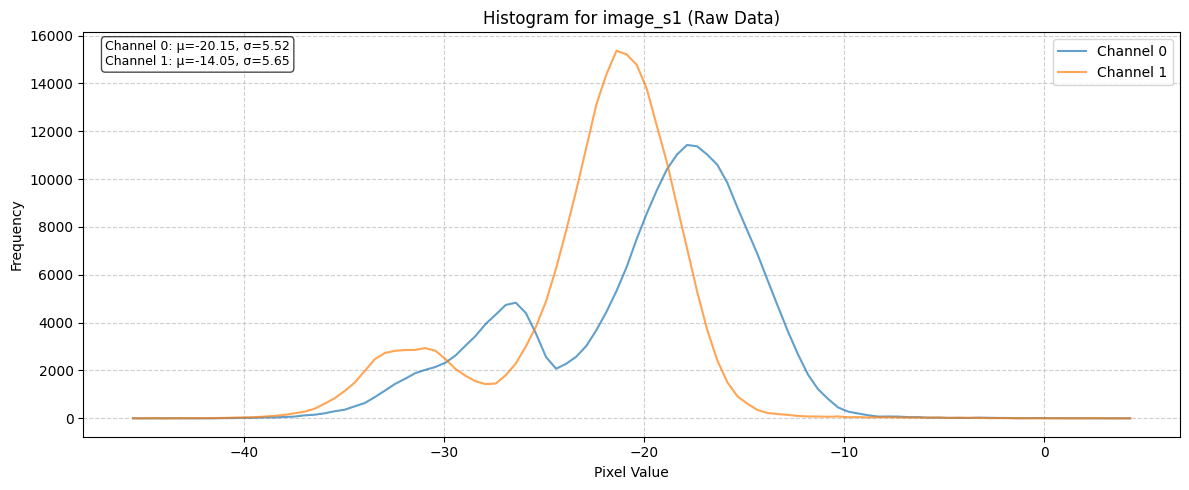

In [7]:
train_dataloader = datamodule.train_dataloader()
raw_batch = next(iter(train_dataloader))

raw_batch_stats = compute_batch_histograms(raw_batch, n_bins=100)

vis_band_order = {
    "s2": [b for b in band_order["s2"] if isinstance(b, str)],
    "s1": [b for b in band_order["s1"] if isinstance(b, str)],
}
raw_figs = plot_batch_histograms(
    raw_batch_stats, vis_band_order, title_suffix=" (Raw Data)"
)

### Effect of different Normalization Schemes

In [ ]:
zscore_normalizer = ZScoreNormalizer(STATS_CLIP_RESCALE_PATH, band_order)
satmae_normalizer = SatMAENormalizer(STATS_SATMAE_PATH, band_order)

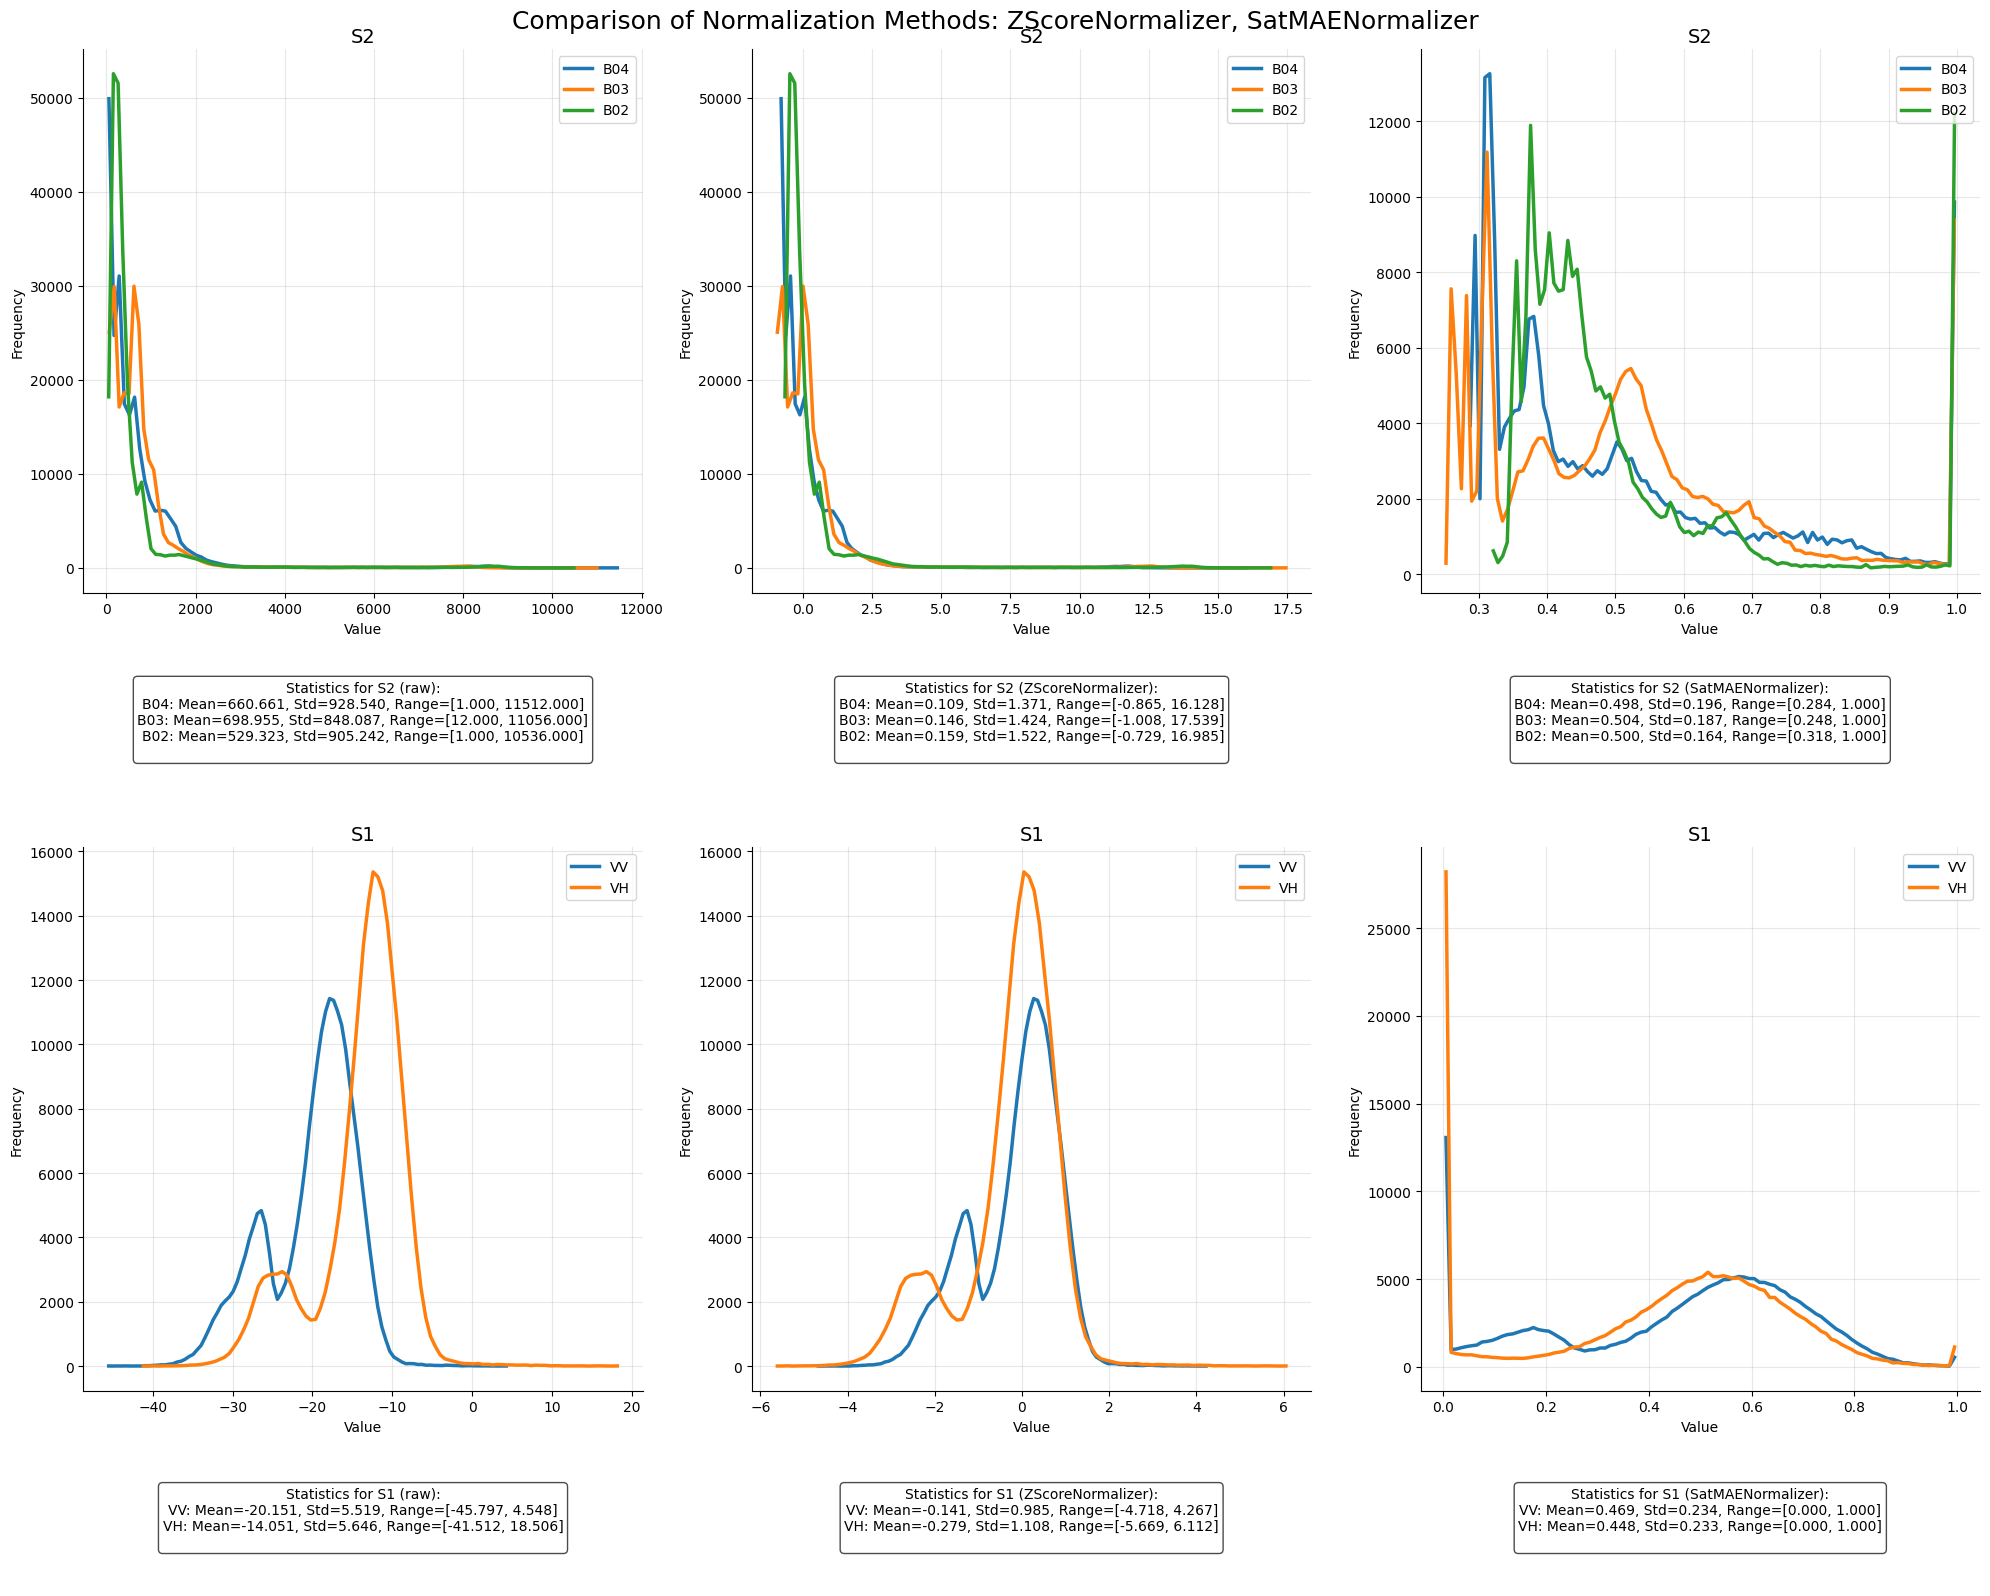

In [8]:
norm_fig, normalized_batches = compare_normalization_methods(
    raw_batch,
    [zscore_normalizer, satmae_normalizer],
    datamodule,
)

## Visualize Batch

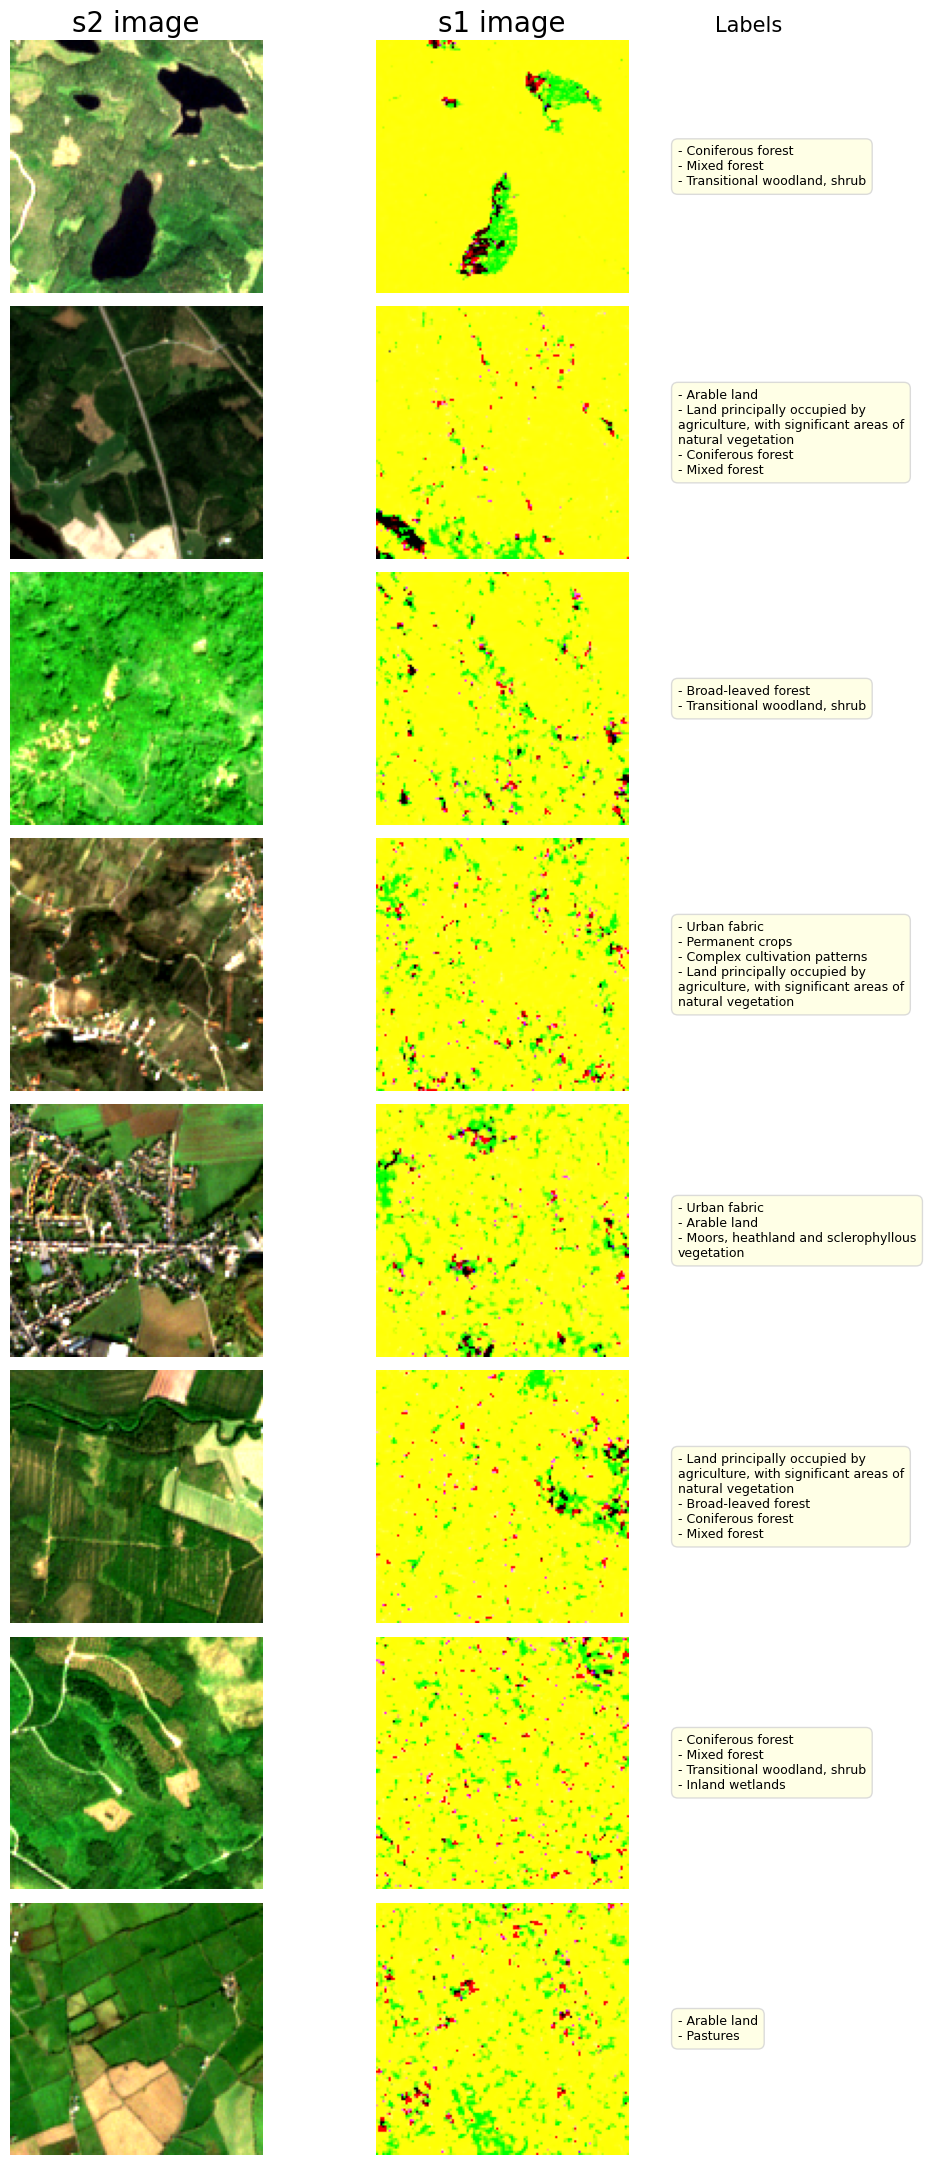

In [10]:
fig, batch = datamodule.visualize_batch()